From https://medium.com/m2mtechconnect/classifying-music-and-speech-with-machine-learning-e036ffab002e

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers, regularizers
from tensorflow.keras import models
#import tensorflow_datasets as tfds

In [2]:
import ffmpeg
from pydub import AudioSegment

In [4]:
#data_dir = pathlib.Path('/root/tensorflow_datasets/downloads/extracted/TAR_GZ.opihi.cs.uvic.ca_sound_music_speechbya81rFcWfLSW6ey5cynqyeq2qiePcL-7asMoNO6IQ0.tar.gz/music_speech')
data_dir   = 'dublin_dl_birds/'
categories = np.array(tf.io.gfile.listdir(data_dir))
categories = [category for category in categories if 'wav' not in category]
categories

['Coal Tit',
 'Common Blackbird',
 'Common Chaffinch',
 'Common Starling',
 'Eurasian Blue Tit',
 'Eurasian Magpie',
 'European Goldfinch',
 'European Greenfinch',
 'European Herring Gull',
 'European Robin',
 'Great Tit',
 'Grey Heron',
 'House Sparrow',
 'Mediterranean Gull',
 'Northern Gannet']

In [4]:
AudioSegment.ffprobe  = "/usr/local/bin/ffmpeg"

In [7]:
wav_check = data_dir
labels = os.listdir(wav_check)
#print(labels)
for lab in labels:
    for sound_f in os.listdir(os.path.join(wav_check,lab)):
        pre, ext = os.path.splitext(os.path.join(wav_check,lab,sound_f))
        #print(ext)
        if ext == '.wav':
            continue
        s_temp   = AudioSegment.from_file(pre+ext)
        mono_audios = s_temp.split_to_mono()
        if len(mono_audios) >=2:
            mono_audios[0].export(pre+'_left.wav', format="wav")
            mono_audios[1].export(pre+'_right.wav', format="wav")
        else:
            mono_audios[0].export(pre+'.wav', format="wav")

In [8]:
#wav_check = data_dir
#labels = os.listdir(wav_check)
#for lab in labels:
#    for sound_f in os.listdir(wav_check+'/'+lab):
#        pre, ext = os.path.splitext(wav_check+'/'+lab+'/'+sound_f)
#        if ext == '.wav':
#            continue
#        s_temp   = AudioSegment.from_file(pre+ext, ext[1:])
#        s_temp.export(pre+'.wav', format="wav")

In [10]:
import re
wav_check = data_dir
labels = os.listdir(wav_check)
for lab in labels:
    dirname = wav_check+'/'+lab
    for sound_f in os.listdir(dirname):
        if re.search('.wav', sound_f) == None:
            os.remove(os.path.join(dirname, sound_f))

In [114]:
import soundfile as sf
def get_waveform_and_label(file_path):
    label        = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    #print(file_path)
    #print(dir(file_path))
    #print(audio_binary)
    #waveform, _  = tf.constant(sf.read(file_path.numpy()))
    waveform     = decode_audio(audio_binary)
    return waveform, label

In [115]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

In [116]:
def decode_audio(audio_binary):
    audio, samp_rate = tf.audio.decode_wav(audio_binary) # returns the WAV-encoded audio as a tensor and the sample rate
    #return tf.squeeze(audio, axis=-1) # removes dimensions of size 1 from the last axis
    return audio[:15*samp_rate,0]

In [117]:
filenames = tf.io.gfile.glob(str(data_dir) + '*/*')
filenames = [filename for filename in filenames if 'wav' in filename]
filenames = tf.random.shuffle(filenames)

In [118]:
filenames

<tf.Tensor: shape=(3954,), dtype=string, numpy=
array([b'dublin_dl_birds\\European Greenfinch\\xc610912.wav',
       b'dublin_dl_birds\\Coal Tit\\xc621357_left.wav',
       b'dublin_dl_birds\\Common Starling\\xc558390_right.wav', ...,
       b'dublin_dl_birds\\Common Starling\\xc647801.wav',
       b'dublin_dl_birds\\Common Chaffinch\\xc665796_right.wav',
       b'dublin_dl_birds\\Eurasian Blue Tit\\xc623520_right.wav'],
      dtype=object)>

In [119]:
np.iinfo(np.int32).max

2147483647

In [120]:
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(pathlib.Path(data_dir)/categories[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 3954
Number of examples per label: 270
Example file tensor: tf.Tensor(b'dublin_dl_birds\\European Greenfinch\\xc610912.wav', shape=(), dtype=string)


In [121]:
TRAIN_SIZE = 0.8

cutoff = int(len(filenames) * TRAIN_SIZE)
train_files = filenames[:cutoff]
test_files  = filenames[cutoff:]

print('Training set size:',   len(train_files))
print('Validation set size:', len(test_files))

Training set size: 3163
Validation set size: 791


In [122]:
AUTOTUNE    = tf.data.experimental.AUTOTUNE
files_ds    = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

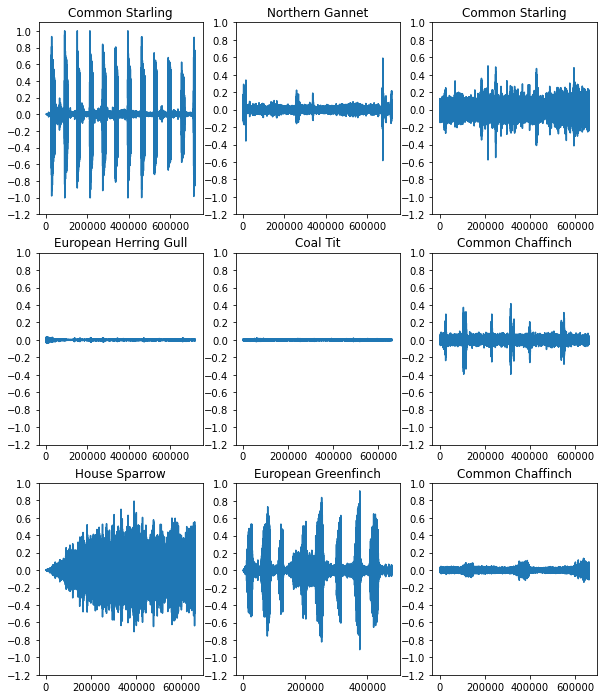

In [84]:
rows = 3
cols = 3
n    = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [123]:
t_shapes = []
f_count = 0
for waveform, label in waveform_ds:
    f_count += 1
    t_shapes.append(int(tf.shape(waveform)[0]))
max_shape_pad = max(t_shapes)
print(f_count)

InvalidArgumentError: Can only read 16-bit WAV files, but received 32
	 [[{{node DecodeWav}}]] [Op:IteratorGetNext]

In [124]:
f_count

1377

In [125]:
train_files[1377]

<tf.Tensor: shape=(), dtype=string, numpy=b'dublin_dl_birds\\Common Blackbird\\xc653609.wav'>

In [135]:
wf,sr = sf.read(train_files[1378].numpy(), dtype='int16')
wf

array([[  -8,  -25],
       [ -26,  -68],
       [ -63, -169],
       ...,
       [ 328,  201],
       [ 622,  522],
       [ 531,  478]], dtype=int16)

In [56]:
np.array(t_shapes).mean()

3498117.097976571

In [57]:
def get_spectrogram(waveform):
    #cutoff spectrogram size to either splice or pad
    pad_cut  = tf.constant([1800, 2*129])
    waveform = tf.cast(waveform, tf.float32)
    
    # produces an array of complex numbers representing magnitude and phase
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128) #frame_step=1 would give spectrogram same length as audio plot

    # removes the phase (we only care about the magnitude)
    spectrogram = tf.abs(spectrogram)
    
    #if length < pad_cut
    ## Concatenate with padding (close to 0) so that all specrograms will be of the same length 
    #else if length > pad_cut
    ## cut off anything in the spectrogram after pad_cut
    zero_padding = tf.cond(tf.shape(spectrogram)[0] > pad_cut[0], 
                          lambda: tf.ones([1,1]), #some basic tensor, won't be used
                          lambda: tf.ones(pad_cut - tf.shape(spectrogram), dtype=tf.float32)*1e-8)
    spectrogram = tf.cond(tf.shape(spectrogram)[0] > pad_cut[0], 
                          lambda: tf.slice(spectrogram, [0,0], [pad_cut[0], 129]), 
                          lambda: tf.concat([spectrogram, zero_padding], 0))

    return spectrogram

In [58]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
# print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: Eurasian Magpie
Waveform shape: (528630,)
Spectrogram shape: (1800, 129)


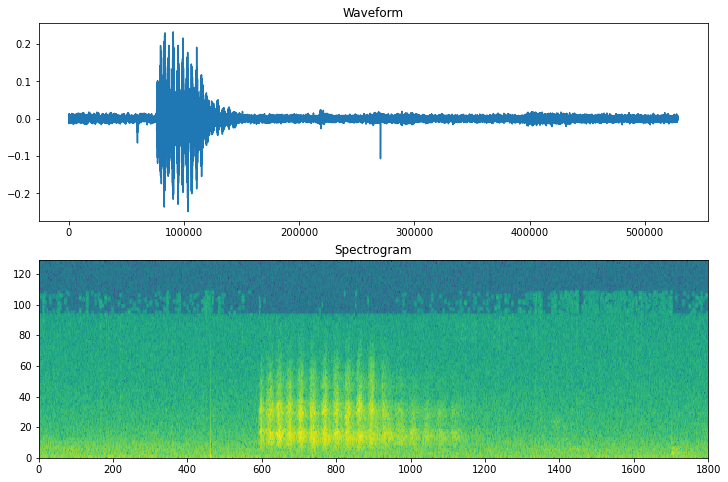

In [59]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    ax.pcolormesh(log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
#axes[0].set_xlim([0, 661500])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [60]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == categories)
    return spectrogram, label_id

In [61]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

In [62]:
def preprocess_dataset(files):
    files_ds  = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

In [63]:
train_ds = spectrogram_ds
test_ds  = preprocess_dataset(test_files)

In [64]:
train_labs = [int(y) for _, y in train_ds]
test_labs  = [int(y) for _, y in test_ds]

InvalidArgumentError: Can only read 16-bit WAV files, but received 32
	 [[{{node DecodeWav}}]] [Op:IteratorGetNext]

In [26]:
train_labs_sort = train_labs
test_labs_sort  = test_labs
train_labs_sort.sort()
test_labs_sort.sort()

Text(0.5, 1.0, 'Test')

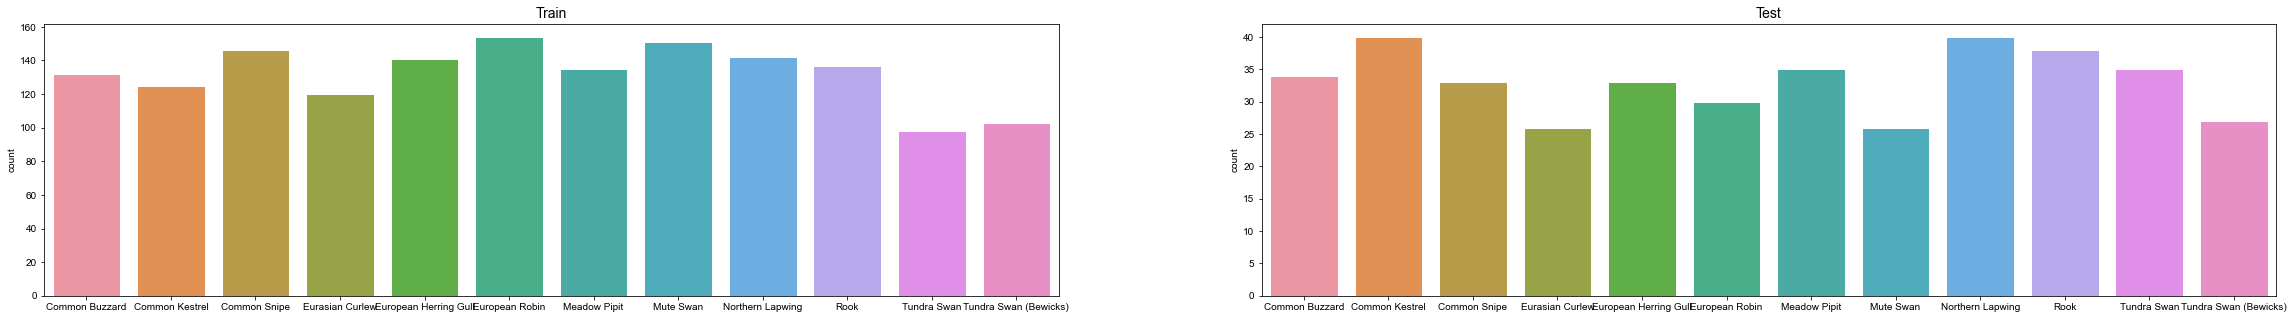

In [27]:
f, axes = plt.subplots(1, 2, figsize = (40,5))
l = []
for i in train_labs_sort:
    l.append(categories[i])
sns.set_style('darkgrid')
sns.countplot(x = l, ax=axes[0])
lb = axes[0].get_xlabel()
axes[0].set_xlabel(lb, fontsize=8)
axes[0].set_title("Train", size = 14)

lt = []
for i in test_labs_sort:
    lt.append(categories[i])
sns.set_style('darkgrid')
sns.countplot(x = lt, ax=axes[1])
lbt = axes[1].get_xlabel()
axes[1].set_xlabel(lbt, fontsize=10)
axes[1].set_title("Test", size = 14)

In [28]:
#test_files

In [29]:
batch_size = 32
train_ds   = train_ds.batch(batch_size)
test_ds    = test_ds.batch(batch_size)
train_ds   = train_ds.cache().prefetch(AUTOTUNE)
test_ds    = test_ds.cache().prefetch(AUTOTUNE)

In [30]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [31]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

print('Input shape:', input_shape)
num_labels = len(categories)

Input shape: (1800, 129, 1)


In [32]:
#norm_layer = preprocessing.Normalization()
#norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

In [33]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    #preprocessing.Resizing(64, 64), 
    #norm_layer,
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 64, 64, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [34]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics   = 'accuracy',
)

In [35]:
EPOCHS = 50
history = model.fit(
    train_ds, 
    validation_data = test_ds,  
    epochs          = EPOCHS,
    #callbacks       = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/50
50/50 [==============================] - 66s 1s/step - loss: 2.7357 - accuracy: 0.0928 - val_loss: 2.5322 - val_accuracy: 0.2116
Epoch 2/50
50/50 [==============================] - 1s 27ms/step - loss: 2.6045 - accuracy: 0.1332 - val_loss: 2.4810 - val_accuracy: 0.2670
Epoch 3/50
50/50 [==============================] - 1s 27ms/step - loss: 2.5306 - accuracy: 0.1572 - val_loss: 2.4326 - val_accuracy: 0.2519
Epoch 4/50
50/50 [==============================] - 1s 27ms/step - loss: 2.4899 - accuracy: 0.1648 - val_loss: 2.3770 - val_accuracy: 0.3023
Epoch 5/50
50/50 [==============================] - 1s 28ms/step - loss: 2.4255 - accuracy: 0.2140 - val_loss: 2.3186 - val_accuracy: 0.3224
Epoch 6/50
50/50 [==============================] - 1s 27ms/step - loss: 2.3803 - accuracy: 0.2197 - val_loss: 2.2662 - val_accuracy: 0.3476
Epoch 7/50
50/50 [==============================] - 1s 26ms/step - loss: 2.3433 - accuracy: 0.2210 - val_loss: 2.2262 - val_accuracy: 0.3552
Epoch 8/50
50/

In [58]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,  
    epochs          = EPOCHS,
    #callbacks       = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/50
50/50 [==============================] - 1s 25ms/step - loss: 1.6876 - accuracy: 0.4766 - val_loss: 1.6572 - val_accuracy: 0.5365
Epoch 2/50
50/50 [==============================] - 1s 27ms/step - loss: 1.6730 - accuracy: 0.4552 - val_loss: 1.6508 - val_accuracy: 0.5365
Epoch 3/50
50/50 [==============================] - 1s 26ms/step - loss: 1.6806 - accuracy: 0.4691 - val_loss: 1.6435 - val_accuracy: 0.5491
Epoch 4/50
50/50 [==============================] - 1s 26ms/step - loss: 1.6538 - accuracy: 0.4886 - val_loss: 1.6356 - val_accuracy: 0.5441
Epoch 5/50
50/50 [==============================] - 1s 26ms/step - loss: 1.6529 - accuracy: 0.4836 - val_loss: 1.6279 - val_accuracy: 0.5416
Epoch 6/50
50/50 [==============================] - 1s 27ms/step - loss: 1.6725 - accuracy: 0.4678 - val_loss: 1.6199 - val_accuracy: 0.5390
Epoch 7/50
50/50 [==============================] - 2s 34ms/step - loss: 1.6264 - accuracy: 0.4785 - val_loss: 1.6126 - val_accuracy: 0.5617
Epoch 8/50
50

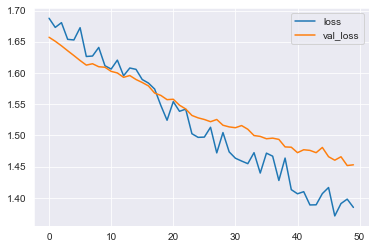

In [59]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

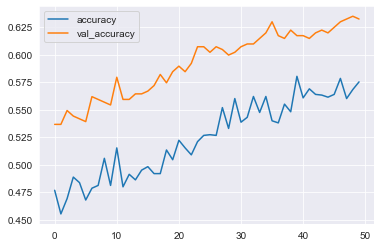

In [60]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [61]:
import plotly.graph_objs as go
metrics = history.history

In [62]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['loss'], 
                         mode = 'lines', name = 'Training',
                         line = dict(color='dodgerblue')))
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['val_loss'], 
                         mode = 'lines', name = 'Validation',
                         line = dict(color='orange')))
fig.update_layout(title='Loss Curve',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')

fig.show()

In [63]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['accuracy'], 
                         mode = 'lines', name = 'Training',
                        line = dict(color='dodgerblue')))
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['val_accuracy'], 
                         mode = 'lines', name = 'Validation',
                        line = dict(color='orange')))
fig.update_layout(title='Accuracy Curve',
                   xaxis_title='Epoch',
                   yaxis_title='Accuracy')

fig.show()

In [64]:
from datetime import datetime

In [65]:
model.save('models/'+datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'richfield_shallow_net')

INFO:tensorflow:Assets written to: models/20211108_235747richfield_shallow_net\assets


In [66]:
#todo: confusion matrix and other 
y_pred = np.argmax(model.predict(test_ds), axis=-1)
y_true = [y for _,y in test_ds.unbatch()]

In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[17,  0,  7,  0,  3,  2,  2,  1,  1,  1,  0,  0],
       [ 2, 35,  2,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 1,  2, 25,  0,  1,  0,  0,  3,  0,  0,  0,  1],
       [ 0,  0,  9, 14,  0,  0,  1,  1,  1,  0,  0,  0],
       [ 0,  2,  1,  1, 23,  0,  1,  2,  0,  0,  3,  0],
       [ 0,  2,  9,  0,  0, 18,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  5, 26,  0,  1,  0,  0,  1],
       [ 0,  0,  5,  2,  1,  2,  0, 14,  1,  0,  1,  0],
       [ 0,  3, 11,  0,  3,  1,  0,  2, 20,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  2,  0, 32,  1,  2],
       [ 2,  1,  4,  0,  2,  0,  0,  7,  0,  0, 18,  1],
       [ 2,  0,  3,  0,  4,  0,  0,  1,  1,  0,  7,  9]], dtype=int64)

In [68]:
import plotly.figure_factory as ff

z = cm

x = categories
y = categories
y.reverse()

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                  yaxis=dict(autorange='reversed')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [46]:
cat_tmp = categories

In [47]:
cat_tmp

['Tundra Swan (Bewicks)',
 'Tundra Swan',
 'Rook',
 'Northern Lapwing',
 'Mute Swan',
 'Meadow Pipit',
 'European Robin',
 'European Herring Gull',
 'Eurasian Curlew',
 'Common Snipe',
 'Common Kestrel',
 'Common Buzzard']

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
y_pred_proba = model.predict(test_ds)[::,1]
#fpr, tpr, _  = roc_curve(y_true,  y_pred_proba)

In [49]:
pred_lists = model.predict(test_ds)

In [50]:
pred_df = pd.DataFrame(pred_lists, columns = categories)

In [51]:
pred_df_softmax = pred_df.apply(lambda x: np.exp(x - np.max(x))/np.exp(x - np.max(x)).sum(), axis=1)

In [52]:
#pred_df_softmax.to_numpy()

In [53]:
from sklearn.preprocessing import OneHotEncoder
onehot_data = OneHotEncoder(sparse=False)
onehot_data = onehot_data.fit_transform(np.array(y_true).reshape(len(y_true),1))

In [54]:
#onehot_data
from itertools import cycle

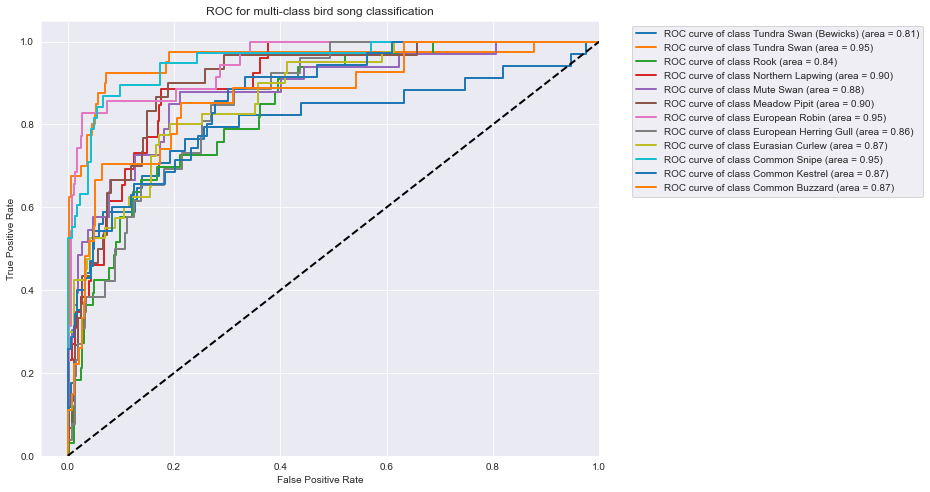

In [55]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(categories)
lw = 2
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(onehot_data[:, i], pred_df_softmax.to_numpy()[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             #color=color, 
             lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(categories[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class bird song classification')
#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.05, 1))#, loc='upper right')
plt.show()

In [56]:
for i in range(n_classes):
    print('AUC of {0}: \t{1:0.2f}'.format(categories[i], roc_auc[i]))

AUC of Tundra Swan (Bewicks): 	0.81
AUC of Tundra Swan: 	0.95
AUC of Rook: 	0.84
AUC of Northern Lapwing: 	0.90
AUC of Mute Swan: 	0.88
AUC of Meadow Pipit: 	0.90
AUC of European Robin: 	0.95
AUC of European Herring Gull: 	0.86
AUC of Eurasian Curlew: 	0.87
AUC of Common Snipe: 	0.95
AUC of Common Kestrel: 	0.87
AUC of Common Buzzard: 	0.87


In [57]:
fig = go.Figure()
#colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i in range(n_classes):
    fig.add_trace(go.Scatter(x = fpr[i], y = tpr[i], 
                             mode = 'lines', 
                             name = 'ROC curve of {0} (area = {1:0.2f})'.format(categories[i], roc_auc[i])))
fig.update_layout(title       = 'ROC for multi-class bird song classification',
                  xaxis_title = 'False Positive Rate',
                  yaxis_title = 'True Positive Rate')

fig.show()